In [9]:
import numpy as np
import pandas as pd
import os

In [11]:
data_path = "./dane/"
df = pd.read_csv(os.path.join(data_path, "dane_spr1.csv"), sep=';')

In [12]:
# wartość optymalizacji po poszczególnym ruchu
optimalization = pd.DataFrame(columns=["Wartosc kombinacji"])
Neighbours_count = 20
improvements = np.zeros(Neighbours_count)

In [13]:
# KR to wartość naszego rozwiązania - ma być najmniejsza
def E(df = df):
    c_sum = df["Czas wykonania"].cumsum() # suma kumultatywna kolumny "Czas wykonania"
    KR = (df["Termin"] - c_sum)**2 # obliczanie kwadratu różnicy wartosći
    return sum(KR) # KR jest wskaźnikiem jakości ułożenia zadań. To optymalizujemy

# wyszukiwanie listy sąsiadów
def get_neighbours(idx, neighbours_count = 20, df = df):
    N = neighbours_count
    # Idea sąsiedztwa dla N = 6 i idx = n E <N/2 ; L-N/2>
    # idx = X, sąsiad = 0, nie sąsiad = -
    # nr_indeksu | ... | n-4 | n-3 | n-2 | n-1 |  n  | n+1 | n+2 | n+3 | n+4 | ... |
    # sasiedztwo |  -  |  -  |  0  |  0  |  0  |  X  |  0  |  0  |  0  |  -  |  -  |
    
    L = len(df) - 1 
    idx_prev = idx # indeks dla ktorego szukamy sasiadow
    N_half = N//2 # polowa wartosci N
    
    # Idea sąsiedztwa dla N = 6 i idx = n < N/2
    # idx = X, sąsiad = 0, nie sąsiad = -
    # przykład n = 2
    # nr_indeksu |  0  |  1  | n=2 |  3  |  4  |  5  |  6  |  7  |  8  |  9  | ... |
    # sasiedztwo |  0  |  0  |  X  |  0  |  0  |  0  |  0  |  -  |  -  |  -  |  -  |
    # skoro nie mozemy znaleźć wystarczająco dużo sąsiadów po lewej, 
    # szukamy dodatkowego po prawej
    if idx < N_half:
        idx = N_half
    # idea sąsiedztwa z ograniczeniem z prawej jest analogiczna do tej z ograniczeniem z lewej
    elif idx > L - N_half:
        idx = L - N_half
    output = list(range(idx - N_half, idx + N_half + 1))
    # usuwanie idx z output
    # TODO: na pewno da się to zrobić prościej
    rm_idx = output.index(idx_prev)
    output = np.array(output)
    output = np.delete(output, rm_idx)
    return output

def swap(idx_1, idx_2, df=df):
    # zamiana miejscami dwóch wierszy "in place" - nie tworzymy nowej ramki danych
    df.iloc[idx_1], df.iloc[idx_2] = df.iloc[idx_2].copy(), df.iloc[idx_1].copy()
    
def move(idx_1, idx_2, df=df):
    swap(idx_1, idx_2) # ruch

def reduce_temperature(T, rate_of_change = .02, sposob = 1):
    return (1-rate_of_change)*T if sposob == 1 else T/(1+rate_of_change*T)

def plot_optimalization(optimalization):
    # TODO: można to zrobić ładniej matplotlibem
    optimalization["Wartosc kombinacji"].plot(kind="line")



In [14]:
R = np.random.randint(len(df)) # losowy numer wiersza
neighbour = get_neighbours(idx=R, neighbours_count=20) # generuj sąsiadów


In [15]:
def simulated_anniling_algorithm(
    T = 2500, 
    Tmin = 100, 
    neighbours_count=20, 
    number_of_generations = 1000
):
    global df
    np.random.seed(42)
    R = np.random.randint(len(df)) # losowy numer wiersza
    KR_before = E()
    optimalization = pd.DataFrame(columns=["Wartosc kombinacji"])
    optimalization = optimalization.append({
                    "Wartosc kombinacji": KR_before
                }, ignore_index=True)
    while T > Tmin:
        while number_of_generations:
            neighbours = get_neighbours(idx=R, neighbours_count=neighbours_count) # generuj sąsiadów
            R_prim = np.random.choice(neighbours) # losowy indeks wiersza
            move(R, R_prim)
            KR_now = E()
            dE = KR_now - KR_before
                        # prawdopodobieństwo przyjęcia gorszego rozwiązania
            if dE < 0 or np.random.rand() < np.exp(-dE/T):
                R = R_prim
            KR_before = KR_now
            # dodawanie obecnej wartości kombinacji do listy wszystkich wartości
            optimalization = optimalization.append({
                    "Wartosc kombinacji": KR_now
                }, ignore_index=True)
            number_of_generations -= 1
        T = reduce_temperature(T)
    order = df["Zadanie"]
    return order, optimalization
            

In [18]:
# df_backup = df # uporządkowanie przed optymalizacją

In [16]:
df = df_backup
new_order, new_optimalization = simulated_anniling_algorithm()

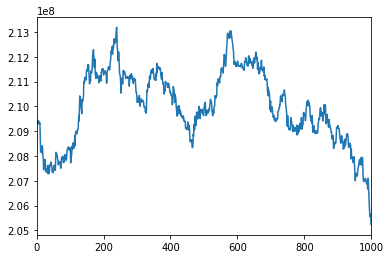

In [17]:
plot_optimalization(new_optimalization)